In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import mylibrary.nnlib as tnn

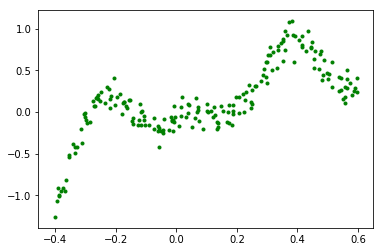

In [2]:
x = np.linspace(0,1,200)
noise = np.random.normal(0,0.02, x.shape)
x = x + noise
y= (2 * np.sin(10*x) + np.cos(20 * x - 3) + 3 * np.log(10*x + 0.5) - 4)/6.
noise = np.random.normal(0,0.1, x.shape)
y = y + noise
x = x - 0.4 #x.mean() # good practice to zero-center x in linear mapping
xx = x.reshape(-1,1)
yy = y.reshape(-1,1)
plt.scatter(x, y, marker='.', color='g')

In [3]:
def inrange(X, break0, break1): #if x is after
    xmsk1 = X >= break0
    xmsk2 = X < break1
    xmsk = np.bitwise_and(xmsk1, xmsk2)
    xs = xmsk #*X
    return xs

In [4]:
def linear_interpolation(X, break_x, break_y):
    x,y = break_x, break_y
    n = len(break_x)
    Y = np.zeros_like(X)
    for i in range(n-1):
        mask = inrange(X, break_x[i], break_x[i+1])
        Y_ = (y[i+1] - y[i])/(x[i+1] - x[i])*(X - x[i]) + y[i]
        Y = Y + Y_*mask
    return Y

In [5]:
def backward(X, dY, break_x, break_y):
    x,y = break_x, break_y
    n = len(break_x)
    Y = np.zeros((n, X.shape[0]))
    inranges = np.zeros((n-1, X.shape[0]))
    consts = np.zeros_like(inranges)
    
    for i in range(n-1):
        inranges[i] = inrange(X, break_x[i], break_x[i+1])
            
    for i in range(n-1):
        consts[i] = ((X-x[i])/(x[i+1] - x[i]))
    
    Y[0] = (-1* consts[0] +1)*inranges[0]
    Y[-1] = consts[-1]*inranges[-1]
    for i in range(1, n-1):
            a = consts[i-1]*inranges[i-1]
            b = (-1* consts[i] +1)*inranges[i]
            Y[i] = a+b
    Y = Y*dY
    ny = np.count_nonzero(inranges, axis=1)
    Y = Y.mean(axis=1)
    return Y

In [6]:
def backward2(X, dY, break_x, break_y):
    x,y = break_x, break_y
    n = len(x)
    XX = np.zeros((n, X.shape[0]))
    inranges = np.zeros((n-1, X.shape[0]))
    consts = np.zeros_like(inranges)
    
    for i in range(n-1):
        inranges[i] = inrange(X, x[i], x[i+1])
            
    for i in range(n-1):
        consts[i] = ((y[i+1]-y[i])/(x[i+1] - x[i])**2)
    
    XX[0] = consts[0]*(X - x[1])*inranges[0]
    XX[-1] = -1*consts[-1]*(X - x[-2])*inranges[-1]
    for i in range(1, n-1):
            a = -1*consts[i-1]*(X - x[i-1])*inranges[i-1]
            b = consts[i]*(X - x[i+1])*inranges[i]
            XX[i] = a+b
    XX = XX*dY
#     nx = np.count_nonzero(inranges, axis=1)
    XX = XX.mean(axis=1)
    return XX

In [7]:
def backward3(X, dY, break_x, break_y):
    x,y = break_x, break_y
    n = len(break_x)
    Y = np.zeros_like(X)
    
    for i in range(n-1):
        Y = Y + (y[i+1] - y[i])/(x[i+1] - x[i])*inrange(X, break_x[i], break_x[i+1])
    
    Y = Y*dY
    return Y

In [8]:
def error_piecewise(X, dY, break_x, break_y):
    x,y = break_x, break_y
    n = len(x)
    XX = np.zeros((n, X.shape[0]))
    dYs = np.zeros((n-1, X.shape[0]))
    for i in range(n-1):
        dYs[i] = dY*inrange(X, x[i], x[i+1])
    dYerr = (dYs**2).mean(axis=1)
    return dYerr

In [9]:
n_breaks1 = 5
n_breaks2 = 5

parmx1 = list(np.sort(np.random.uniform(x.min(), x.max(), size=(n_breaks1-2))))
parmx1 = np.array([x.min()-0.2]+parmx1+[x.max()+0.2])
parmy1 = np.sort(np.random.uniform(y.min(), y.max(), size=(n_breaks1)))
print(parmx1)
print(parmy1)
print()
parmx2 = np.sort(np.random.uniform(y.min(), y.max(), size=(n_breaks2)))
parmy2 = np.sort(np.random.uniform(y.min(), y.max(), size=(n_breaks2)))
print(parmx2)
print(parmy2)

[-0.62094964 -0.22734758  0.52085085  0.52553192  0.80773312]
[-0.50324398 -0.39688798 -0.38040593 -0.18507199  0.93352117]

[-1.39573852 -0.31652317 -0.29833188  0.63846382  0.77884536]
[-1.29624841 -1.24656809 -0.84437703 -0.79487256 -0.08866567]


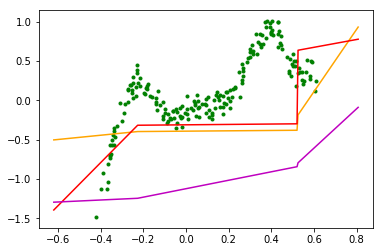

In [10]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.plot(parmx1, parmy1, color='orange')
plt.plot(parmx1, parmx2, color='r')
plt.plot(parmx1, parmy2, color='m')

In [13]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

lr=0.1
for step in range(10000):
    A1 = linear_interpolation(x, parmx1, parmy1)
    A2 = linear_interpolation(A1, parmx2, parmy2)
    dA2 = A2 - y
    
    dparmy2 = backward(A1, dA2, parmx2, parmy2)
    dparmx2 = backward2(A1, dA2, parmx2, parmy2)
    dA1 = backward3(A1, dA2, parmx2, parmy2)
    
    dparmy1 = backward(x, dA1, parmx1, parmy1)
    dparmx1 = backward2(x, dA1, parmx1, parmy1)
    dX = backward3(x, dA1, parmx1, parmy1)
    
    
    parmy2 = parmy2 - dparmy2 * lr # update
    parmx2 = parmx2 - dparmx2 * lr
    parmy1 = parmy1 - dparmy1 * lr # update
    parmx1 = parmx1 - dparmx1 * lr
    
    
    # sorting the points for everything :D
    sortindx1 = np.argsort(parmx1)
    parmx1 = parmx1[sortindx1]
    parmy1 = parmy1[sortindx1]
    
    sortindx2 = np.argsort(parmx2)
    parmx2 = parmx2[sortindx2]
    parmy2 = parmy2[sortindx2]
    
#     if step % 100 == 0:
#         # postprocessing the splines
#         # removing ones which are very close to each other
#         parmx_grad = np.gradient(parmx)
#         clipmask = np.abs(parmx_grad) > 1e-2
#         parmx = parmx[clipmask]
#         parmy = parmy[clipmask]
        
#         # removing the ones which are on same line
#         triangle = np.ones_like(parmx)
#         for i in range(len(parmx)-2):
#             triangle[i+1] = 0.5*np.abs(
#                 (parmx[i] - parmx[i+2])*(parmy[i+1] - parmy[i])-
#                 (parmx[i] - parmx[i+1])*(parmy[i+2] - parmy[i]))
#         mergemask = triangle > 1e-2
#         parmx = parmx[mergemask]
#         parmy = parmy[mergemask]
        
#         # adding units where the 
# #         for _ in range(len(parmx), n_breaks):
#         if len(parmx)< n_breaks:
#             Y = linear_interpolation(x, parmx, parmy)
#             dyerr = error_piecewise(x, Y-y, parmx, parmy)
#             index = np.argmax(dyerr)
#             newpx = (parmx[index] + parmx[index+1])/2.
#             newpy = (parmy[index] + parmy[index+1])/2.
#             # adding new interpolation points
#             parmx = np.append(parmx, newpx)
#             parmy = np.append(parmy, newpy)
#             # sorting the points for plotting
#             sortindx = np.argsort(parmx)
#             parmx = parmx[sortindx]
#             parmy = parmy[sortindx]
        
        
    if step % 10 == 0:
            
        error = (dA2**2).mean()
        
        print('_______________________')
        print("Steps", step)
        print("Error", error)
        
        
        ax.clear()
        plt.scatter(x, y, marker='.', color='g')
        
        plt.plot(parmx1, parmy1, marker='.', color='m')
        plt.plot(parmx2, parmy2, marker='.', color='b')
        
#         plt.scatter(x, dX, marker='.', color='c')
        A1 = linear_interpolation(x, parmx1, parmy1)
        Y = linear_interpolation(A1, parmx2, parmy2)
        plt.scatter(x, Y, marker='.', color='r')

        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            plt.pause(50)
            break

_______________________
Steps 0
Error 1.5015298585333576


_______________________
Steps 10
Error 0.4032083247081323


_______________________
Steps 20
Error 0.22204735441192625


_______________________
Steps 30
Error 0.1337591886027729


_______________________
Steps 40
Error 0.11137782651999327


_______________________
Steps 50
Error 0.10631819973413734


_______________________
Steps 60
Error 0.09952953944672828


_______________________
Steps 70
Error 0.0935848936744533


_______________________
Steps 80
Error 0.08690883232521751


_______________________
Steps 90
Error 0.08162903686630746


_______________________
Steps 100
Error 0.07602274345077355


_______________________
Steps 110
Error 0.06727920639098986


_______________________
Steps 120
Error 0.061457590108825164


_______________________
Steps 130
Error 0.05695257861768858


_______________________
Steps 140
Error 0.05515303381252397


_______________________
Steps 150
Error 0.05152396225837366


______________________



_______________________
Steps 1330
Error 0.038268894120729445


_______________________
Steps 1340
Error 0.038051547322387025


_______________________
Steps 1350
Error 0.038264314250189585


_______________________
Steps 1360
Error 0.038047662136650846


_______________________
Steps 1370
Error 0.03825976759049049


_______________________
Steps 1380
Error 0.03804383351324178


_______________________
Steps 1390
Error 0.03825530241754215


_______________________
Steps 1400
Error 0.03804008917307043


_______________________
Steps 1410
Error 0.03825093187666594


_______________________
Steps 1420
Error 0.03803643399698556


_______________________
Steps 1430
Error 0.038246655393600684


_______________________
Steps 1440
Error 0.03803286440086269


_______________________
Steps 1450
Error 0.038242467659424205


_______________________
Steps 1460
Error 0.03802937424879736


_______________________
Steps 1470
Error 0.0382383622605941


_______________________
Steps 1480
Error 0.03802

TclError: this isn't a Tk application

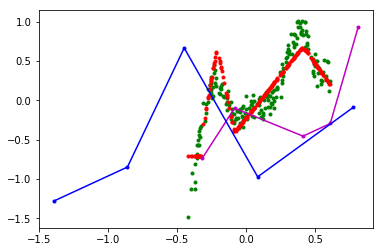

In [16]:
%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.plot(parmx1, parmy1, marker='.', color='m')
plt.plot(parmx2, parmy2, marker='.', color='b')
# plt.scatter(x, dX, marker='.', color='c')
A1 = linear_interpolation(x, parmx1, parmy1)
Y = linear_interpolation(A1, parmx2, parmy2)
plt.scatter(x, Y, marker='.', color='r')

In [27]:
# # adding new interpolation points
# parmx = np.append(parmx, 0.53)
# parmy = np.append(parmy, 0.0)
# # sorting the points for plotting
# sortindx = np.argsort(parmx)
# parmx = parmx[sortindx]
# parmy = parmy[sortindx]

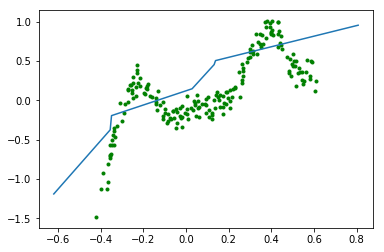

In [39]:
n_breaks = 7
parmx = list(np.sort(np.random.uniform(x.min(), x.max(), size=(n_breaks-2))))
parmx = np.array([x.min()-0.2]+parmx+[x.max()+0.2])
parmy = np.sort(np.random.uniform(y.min(), y.max(), size=(n_breaks)))
linear = tnn.LinearLayer(1,1, optimizer=tnn.SGD(0.1))

%matplotlib inline
plt.scatter(x, y, marker='.', color='g')
plt.plot(parmx, parmy)

In [40]:
%matplotlib tk
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

lr=0.1
for step in range(10000):
    x_ = linear.forward(x.reshape(-1,1)).reshape(-1)
    Y = linear_interpolation(x_, parmx, parmy)
    dy = Y-y
    dparmy = backward(x_, dy, parmx, parmy)
    dparmx = backward2(x_, dy, parmx, parmy)
    dx_ = backward3(x_, dy, parmx, parmy)
    dx = linear.backward(dx_.reshape(-1,1)).reshape(-1)
    
    parmy = parmy - dparmy * lr # update
    parmx = parmx - dparmx * lr
    linear.update()
    
    # sorting the points for everything :D
    sortindx = np.argsort(parmx)
    parmx = parmx[sortindx]
    parmy = parmy[sortindx]
    
    if step % 100 == 0:
        # postprocessing the splines
        # removing ones which are very close to each other
        parmx_grad = np.gradient(parmx)
        clipmask = np.abs(parmx_grad) > 1e-2
        parmx = parmx[clipmask]
        parmy = parmy[clipmask]
        
        # removing the ones which are on same line
        triangle = np.ones_like(parmx)
        for i in range(len(parmx)-2):
            triangle[i+1] = 0.5*np.abs(
                (parmx[i] - parmx[i+2])*(parmy[i+1] - parmy[i])-
                (parmx[i] - parmx[i+1])*(parmy[i+2] - parmy[i]))
        mergemask = triangle > 1e-2
        parmx = parmx[mergemask]
        parmy = parmy[mergemask]
        
        # adding units where the 
#         for _ in range(len(parmx), n_breaks):
        if len(parmx)< n_breaks:
            Y = linear_interpolation(x_, parmx, parmy)
            dyerr = error_piecewise(x_, Y-y, parmx, parmy)
            index = np.argmax(dyerr)
            newpx = (parmx[index] + parmx[index+1])/2.
            newpy = (parmy[index] + parmy[index+1])/2.
            # adding new interpolation points
            parmx = np.append(parmx, newpx)
            parmy = np.append(parmy, newpy)
            # sorting the points for plotting
            sortindx = np.argsort(parmx)
            parmx = parmx[sortindx]
            parmy = parmy[sortindx]
        
        
    if step % 10 == 0:
            
        error = (dy**2).mean()
        
        print('_______________________')
        print("Steps", step)
        print("Error", error)
        print("parmx", parmx.shape)
        
        
        ax.clear()
        plt.scatter(x, y, marker='.', color='g')
        plt.scatter(x, x_, marker='.', color='c')
        plt.scatter(x_, y, marker='.', color='b')
        
        plt.plot(parmx, parmy, marker='.', color='r')
        x_ = linear.forward(x.reshape(-1,1)).reshape(-1)
        Y = linear_interpolation(x_, parmx, parmy)
        plt.scatter(x, Y, marker='.', color='r')
        

        
        fig.canvas.draw()
        plt.pause(0.01)
        print("\n")
        if error < 0.00025:
            print('fitted to our expectation')
            plt.pause(50)
            break

_______________________
Steps 0
Error 0.12330946395467145
parmx (7,)


_______________________
Steps 10
Error 0.061965563692842555
parmx (7,)


_______________________
Steps 20
Error 0.0787492178124626
parmx (7,)


_______________________
Steps 30
Error 0.05404085068157324
parmx (7,)


_______________________
Steps 40
Error 0.050116958424392
parmx (7,)


_______________________
Steps 50
Error 0.04700629038890375
parmx (7,)


_______________________
Steps 60
Error 0.04291843817581296
parmx (7,)


_______________________
Steps 70
Error 0.04982125406542021
parmx (7,)


_______________________
Steps 80
Error 0.05690464781083002
parmx (7,)


_______________________
Steps 90
Error 0.038899413129938186
parmx (7,)


_______________________
Steps 100
Error 0.06218841111588078
parmx (7,)


_______________________
Steps 110
Error 0.05552368315136309
parmx (7,)


_______________________
Steps 120
Error 0.0541029772785217
parmx (7,)


_______________________
Steps 130
Error 0.053724680486881934
par



_______________________
Steps 1130
Error 0.021241655473694002
parmx (7,)


_______________________
Steps 1140
Error 0.02147264354872033
parmx (7,)


_______________________
Steps 1150
Error 0.021529378419220806
parmx (7,)


_______________________
Steps 1160
Error 0.02149445322034669
parmx (7,)


_______________________
Steps 1170
Error 0.021468017500067903
parmx (7,)


_______________________
Steps 1180
Error 0.021548134861960645
parmx (7,)


_______________________
Steps 1190
Error 0.02146860061583186
parmx (7,)


_______________________
Steps 1200
Error 0.02148093758655255
parmx (7,)


_______________________
Steps 1210
Error 0.021509967838334143
parmx (7,)


_______________________
Steps 1220
Error 0.021528024259614673
parmx (7,)


_______________________
Steps 1230
Error 0.021534315424109565
parmx (7,)


_______________________
Steps 1240
Error 0.02150061380135743
parmx (7,)


_______________________
Steps 1250
Error 0.02153201694636253
parmx (7,)


_______________________
Steps



_______________________
Steps 2240
Error 0.02148089638123294
parmx (7,)


_______________________
Steps 2250
Error 0.02138961489581484
parmx (7,)


_______________________
Steps 2260
Error 0.02135901793619416
parmx (7,)


_______________________
Steps 2270
Error 0.021563235536204123
parmx (7,)


_______________________
Steps 2280
Error 0.021590480320276776
parmx (7,)


_______________________
Steps 2290
Error 0.021640081146287314
parmx (7,)


_______________________
Steps 2300
Error 0.021414272002598586
parmx (7,)


_______________________
Steps 2310
Error 0.021577851940780476
parmx (7,)


_______________________
Steps 2320
Error 0.02149305789524027
parmx (7,)


_______________________
Steps 2330
Error 0.02151981098665306
parmx (7,)


_______________________
Steps 2340
Error 0.021450090422174856
parmx (7,)


_______________________
Steps 2350
Error 0.021675154321200665
parmx (7,)


_______________________
Steps 2360
Error 0.021402598483738922
parmx (7,)


_______________________
Step



_______________________
Steps 3340
Error 0.021708043289549544
parmx (7,)


_______________________
Steps 3350
Error 0.02162782589222655
parmx (7,)


_______________________
Steps 3360
Error 0.02162453766146985
parmx (7,)


_______________________
Steps 3370
Error 0.02160931180443526
parmx (7,)


_______________________
Steps 3380
Error 0.021507456267184658
parmx (7,)


_______________________
Steps 3390
Error 0.021456103745120508
parmx (7,)


_______________________
Steps 3400
Error 0.02170473271190344
parmx (7,)


_______________________
Steps 3410
Error 0.021522003533432636
parmx (7,)


_______________________
Steps 3420
Error 0.021234564396334178
parmx (7,)


_______________________
Steps 3430
Error 0.021314819490583458
parmx (7,)


_______________________
Steps 3440
Error 0.02167057355815725
parmx (7,)


_______________________
Steps 3450
Error 0.02144927141676607
parmx (7,)


_______________________
Steps 3460
Error 0.021631241686132077
parmx (7,)


_______________________
Steps



_______________________
Steps 4450
Error 0.021327325512268104
parmx (7,)


_______________________
Steps 4460
Error 0.02149279334316545
parmx (7,)


_______________________
Steps 4470
Error 0.021238890548327474
parmx (7,)


_______________________
Steps 4480
Error 0.02128881255914469
parmx (7,)


_______________________
Steps 4490
Error 0.021423787705850534
parmx (7,)


_______________________
Steps 4500
Error 0.021666973640794406
parmx (7,)


_______________________
Steps 4510
Error 0.021253367978916523
parmx (7,)


_______________________
Steps 4520
Error 0.021348552094089854
parmx (7,)


_______________________
Steps 4530
Error 0.021514520370309702
parmx (7,)


_______________________
Steps 4540
Error 0.021511273321177304
parmx (7,)


_______________________
Steps 4550
Error 0.021202473667683207
parmx (7,)


_______________________
Steps 4560
Error 0.021225356945740462
parmx (7,)


_______________________
Steps 4570
Error 0.021311055795902884
parmx (7,)


_______________________
S



_______________________
Steps 5550
Error 0.021186475910489194
parmx (7,)


_______________________
Steps 5560
Error 0.021184349960098728
parmx (7,)


_______________________
Steps 5570
Error 0.021182235537798553
parmx (7,)


_______________________
Steps 5580
Error 0.021180130038329956
parmx (7,)


_______________________
Steps 5590
Error 0.021178030664064717
parmx (7,)


_______________________
Steps 5600
Error 0.021175934382917348
parmx (7,)


_______________________
Steps 5610
Error 0.02117384154425781
parmx (7,)


_______________________
Steps 5620
Error 0.021157370440711684
parmx (7,)


_______________________
Steps 5630
Error 0.02113771587327475
parmx (7,)


_______________________
Steps 5640
Error 0.021118666159938227
parmx (7,)


_______________________
Steps 5650
Error 0.021124053300987468
parmx (7,)


_______________________
Steps 5660
Error 0.021193935074245735
parmx (7,)


_______________________
Steps 5670
Error 0.02119800445761526
parmx (7,)


_______________________
St



_______________________
Steps 6660
Error 0.021221678480733565
parmx (7,)


_______________________
Steps 6670
Error 0.021192219869752026
parmx (7,)


_______________________
Steps 6680
Error 0.021165302615858746
parmx (7,)


_______________________
Steps 6690
Error 0.02117462401917923
parmx (7,)


_______________________
Steps 6700
Error 0.021253587128316077
parmx (7,)


_______________________
Steps 6710
Error 0.021222779189405395
parmx (7,)


_______________________
Steps 6720
Error 0.021191812673102186
parmx (7,)


_______________________
Steps 6730
Error 0.021163842477851035
parmx (7,)


_______________________
Steps 6740
Error 0.02117189506664351
parmx (7,)


_______________________
Steps 6750
Error 0.02124884801660746
parmx (7,)


_______________________
Steps 6760
Error 0.02121719821414447
parmx (7,)


_______________________
Steps 6770
Error 0.02118584351062699
parmx (7,)


_______________________
Steps 6780
Error 0.021157678320150478
parmx (7,)


_______________________
Step

TclError: this isn't a Tk application

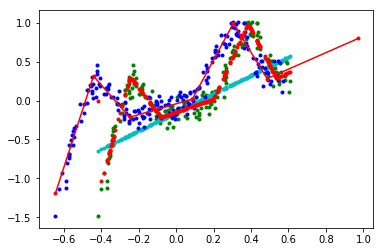

In [43]:
%matplotlib inline

plt.scatter(x, y, marker='.', color='g')
plt.scatter(x, x_, marker='.', color='c')
plt.scatter(x_, y, marker='.', color='b')

plt.plot(parmx, parmy, marker='.', color='r')
x_ = linear.forward(x.reshape(-1,1)).reshape(-1)
Y = linear_interpolation(x_, parmx, parmy)
plt.scatter(x, Y, marker='.', color='r')